# [Lab Session 4](deconvolution.ipynb)

In [12]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.restoration import wiener
from scipy.signal import convolve2d as conv
from scipy.stats import multivariate_normal as multi_normal

np.random.seed(0)

Load the image.

(256, 256)


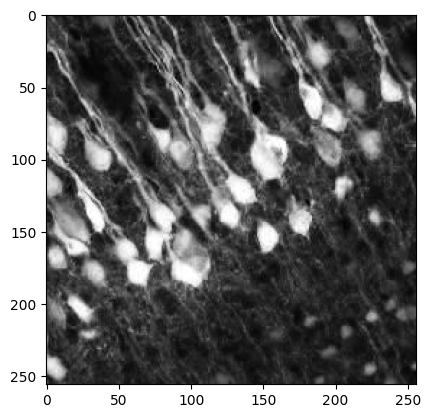

In [13]:
img = plt.imread('data/cells.png')[128:384, 128:384]
plt.imshow(img, 'gray')
print(img.shape)


Die PSF ist True-Image * PSF = Acquired Image
wenn wir PSF und Aquired Image gegeben haben: Acquired Image * (PSF)^-1 = Deconvoluted Image.
Es gibt verschiedene Methoden um Deconvolution mit bekannter PSF zu machen: Inverser Filter, Wiener Filter, etc

**[Task 1.]()** Apply the following PSF to the image and then display it.

In [14]:
psf_size = 10
psf = np.ones((psf_size, psf_size)) / psf_size ** 2
print(psf.shape)

(10, 10)


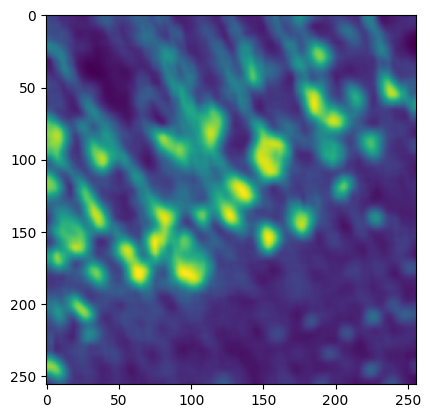

In [15]:
img_psf = conv(img, psf, mode='same',
boundary='symm')
plt.imshow(img_psf)

**[Task 2.]()** Have a look at the Gaussian PSF which is not uniformly distributed. Apply it to the image.

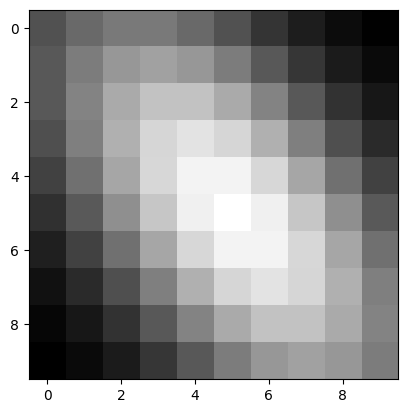

In [16]:
def create_psf(size):
    factor = size * 1.8
    x, y = np.mgrid[0:size:1, 0:size:1]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y
    rv = multi_normal([int(size / 2), (int(size / 2))], [[factor * 1., factor * 1.2], [factor * .5, factor * .7]])
    return rv.pdf(pos)

plt.imshow(create_psf(psf_size), 'gray')

Apply the second psf to the image:

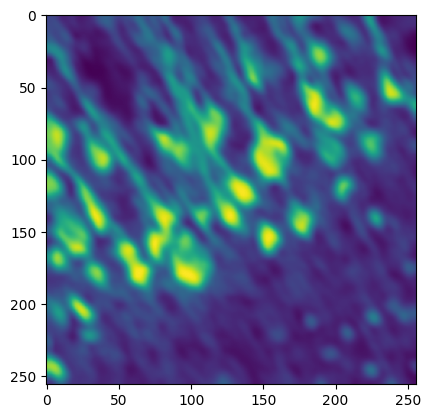

In [17]:
img_psf2 = conv(img, create_psf(psf_size), mode='same',
boundary='symm')
plt.imshow(img_psf2)

**[Task 3.]()** Implement a reusable function that performs the Richardson-Lucy deconvolution.

In [71]:
def richardson_lucy_deconvolution(image, psf, n_iterations):
    img_deconv = np.full(image.shape, 0.5)

    for i in range(n_iterations + 1):
        a = conv(img_deconv, psf, mode='same', boundary='symm')
        b = image / a
        c = conv(b, np.flip(psf), mode='same', boundary='symm')
        img_deconv = img_deconv * c


    img_deconv = img_deconv.clip(0,1)
    return img_deconv

**[Task 4.]()** Apply the Richardson-Lucy deconvolution to the blurred image.

In [80]:
deconv_img = richardson_lucy_deconvolution(img_psf, psf, 150)

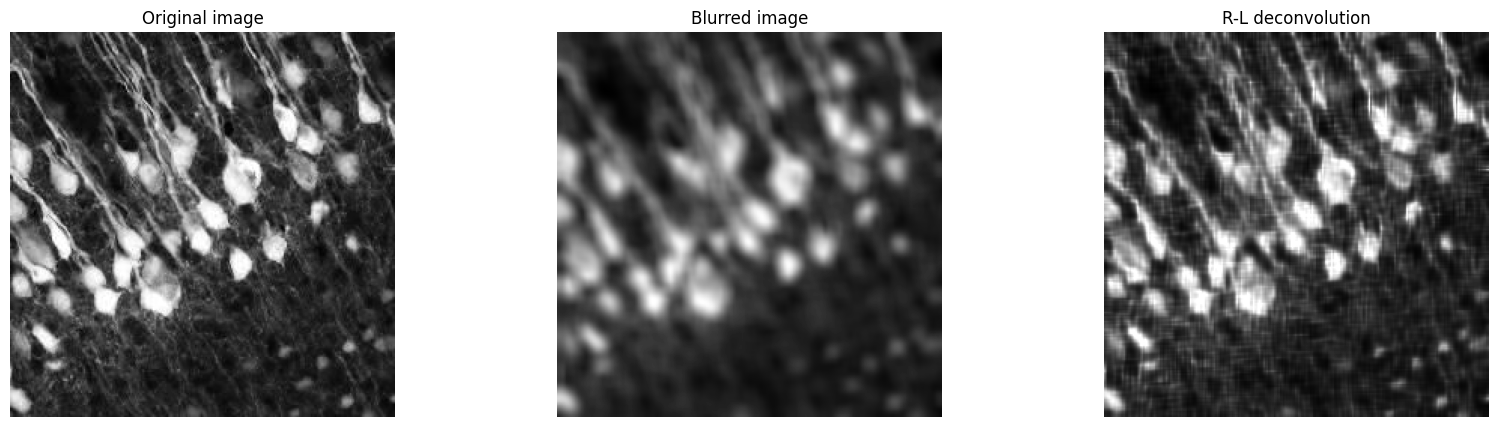

In [81]:
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(img, 'gray')
plt.title('Original image')
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(img_psf, 'gray')
plt.title('Blurred image')
plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(deconv_img, 'gray')
plt.title('R-L deconvolution')
plt.show()

Bei 1 iteration wird das blurring nicht wirklich verbessert
Bei 1.500 kommt ein verpixeltes Bild heraus

**[Task 5.]()** Add noise to the image, use the R-L deconvolution again.

In [83]:
noise = (np.random.normal(loc=0,size=img.shape))
reduce_factor = 5
noise = noise / reduce_factor

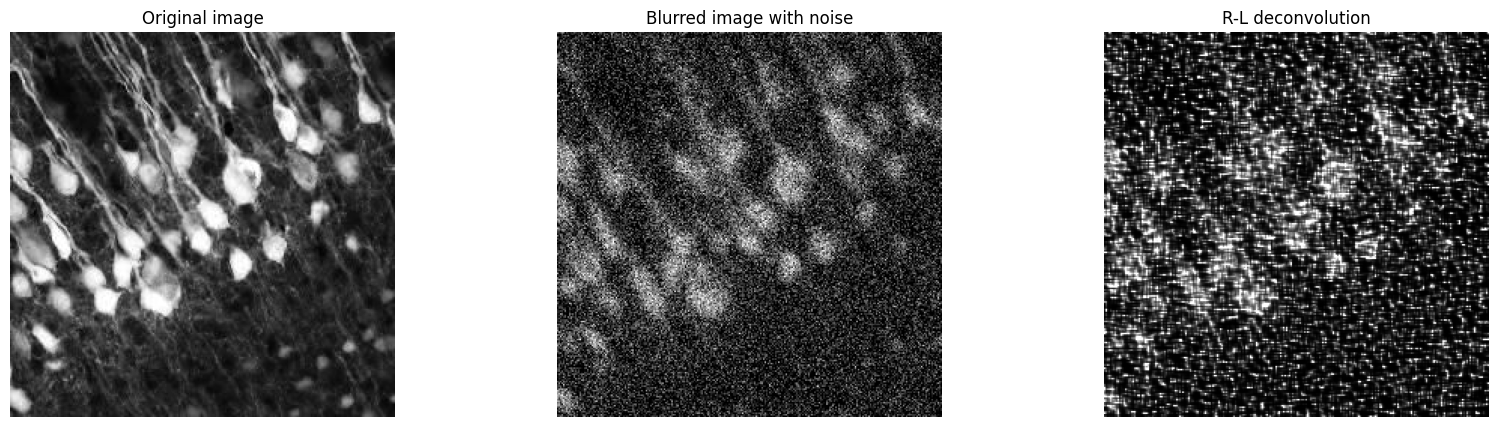

In [87]:
#adding noise
img_psf2_n = img_psf2 + noise

#clipping image
img_psf2_n = img_psf2_n.clip(0,1)

#Deconvolution R-L
deconv_img_psf2_n = richardson_lucy_deconvolution(img_psf2_n, create_psf(psf_size), 50)

#Display results
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(img, 'gray')
plt.title('Original image')
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(img_psf2_n, 'gray')
plt.title('Blurred image with noise')
plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(deconv_img_psf2_n, 'gray')
plt.title('R-L deconvolution')
plt.show()

**[Task 6.]()** Compare your R-L implementation to a wiener deconvolution.

**[Task 7.]()** Repeat Tasks 4–6 using a smaller value for the size of the PSF.

**[Task 8.]()** Use a wrong PSF to restore the image